In [1]:
pip install tensorflow matplotlib

Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import layers
from keras.datasets import mnist



In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  1


In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    except RuntimeError as e:
        print(e)
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
import tensorflow as tf
from tensorflow.python.client import device_lib

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Device List: ", device_lib.list_local_devices())


Num GPUs Available:  1
Device List:  [name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6337766184219579814
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4160159744
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17113875992846130126
physical_device_desc: "device: 0, name: GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [5]:
import tensorflow as tf
import timeit

# Utwórz macierz i wykonaj operację na CPU i GPU
with tf.device('/CPU:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(128, 3)(random_image_cpu)

with tf.device('/GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(128, 3)(random_image_gpu)

print("CPU: ", timeit.timeit(lambda: tf.keras.layers.Conv2D(128, 3)(random_image_cpu), number=10))
print("GPU: ", timeit.timeit(lambda: tf.keras.layers.Conv2D(128, 3)(random_image_gpu), number=10))

CPU:  0.9100669000000607
GPU:  0.8974279000000251


In [6]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

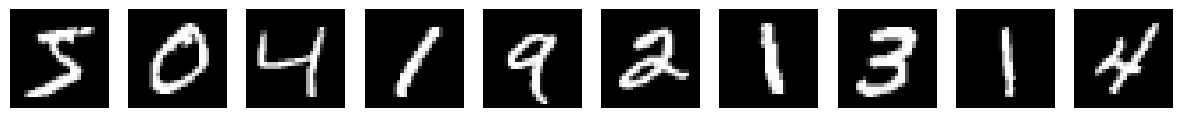

In [7]:
num_images = 10
plt.figure(figsize=(15, 5))
for i in range(num_images):
    plt.subplot(1, num_images, i + 1)
    plt.imshow(x_train[i], cmap='gray')
    plt.axis('off')
plt.show()

In [8]:
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

x_train = np.reshape(x_train, (-1, 28, 28, 1))
x_test = np.reshape(x_test, (-1, 28, 28, 1))

In [24]:
latent_dim = 2
input_shape = (28, 28, 1)

# Budowa enkodera
encoder_inputs = tf.keras.Input(shape=input_shape)
x = layers.Conv2D(32, 3, activation='relu', strides=2, padding='same')(encoder_inputs)
x = layers.Conv2D(64, 3, activation='relu', strides=2, padding='same')(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation='relu')(x)
z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)

In [25]:
def sampling(args):
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.keras.backend.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])


In [26]:
decoder_inputs = tf.keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation='relu')(decoder_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')(x)
x = layers.Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation='sigmoid', padding='same')(x)

encoder = tf.keras.Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')
decoder = tf.keras.Model(decoder_inputs, decoder_outputs, name='decoder')

In [30]:
vae_outputs = decoder(encoder(encoder_inputs)[2])
vae = tf.keras.Model(encoder_inputs, vae_outputs, name='vae')

reconstruction_loss = tf.keras.losses.binary_crossentropy(tf.keras.backend.flatten(encoder_inputs), tf.keras.backend.flatten(vae_outputs))
reconstruction_loss *= 28 * 28
kl_loss = 1 + z_log_var - tf.keras.backend.square(z_mean) - tf.keras.backend.exp(z_log_var)
kl_loss = tf.keras.backend.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = tf.keras.backend.mean(reconstruction_loss + kl_loss)

vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

vae.fit(x_train, epochs=100, batch_size=128, validation_data=(x_test, None))

Epoch 1/100
469/469 [==============================] - 9s 17ms/step - loss: 148.5454 - val_loss: 150.9206
Epoch 2/100
469/469 [==============================] - 7s 15ms/step - loss: 148.5270 - val_loss: 150.9153
Epoch 3/100
469/469 [==============================] - 7s 15ms/step - loss: 148.4112 - val_loss: 150.9640
Epoch 4/100
469/469 [==============================] - 7s 15ms/step - loss: 148.3857 - val_loss: 151.3860
Epoch 5/100
469/469 [==============================] - 7s 15ms/step - loss: 148.4170 - val_loss: 150.9041
Epoch 6/100
469/469 [==============================] - 7s 15ms/step - loss: 148.1737 - val_loss: 150.8786
Epoch 7/100
469/469 [==============================] - 7s 15ms/step - loss: 148.2608 - val_loss: 150.5168
Epoch 8/100
469/469 [==============================] - 7s 15ms/step - loss: 148.1596 - val_loss: 150.8856
Epoch 9/100
469/469 [==============================] - 7s 15ms/step - loss: 148.0565 - val_loss: 150.8009
Epoch 10/100
469/469 [========================

1/1 [==============================] - 0s 23ms/step


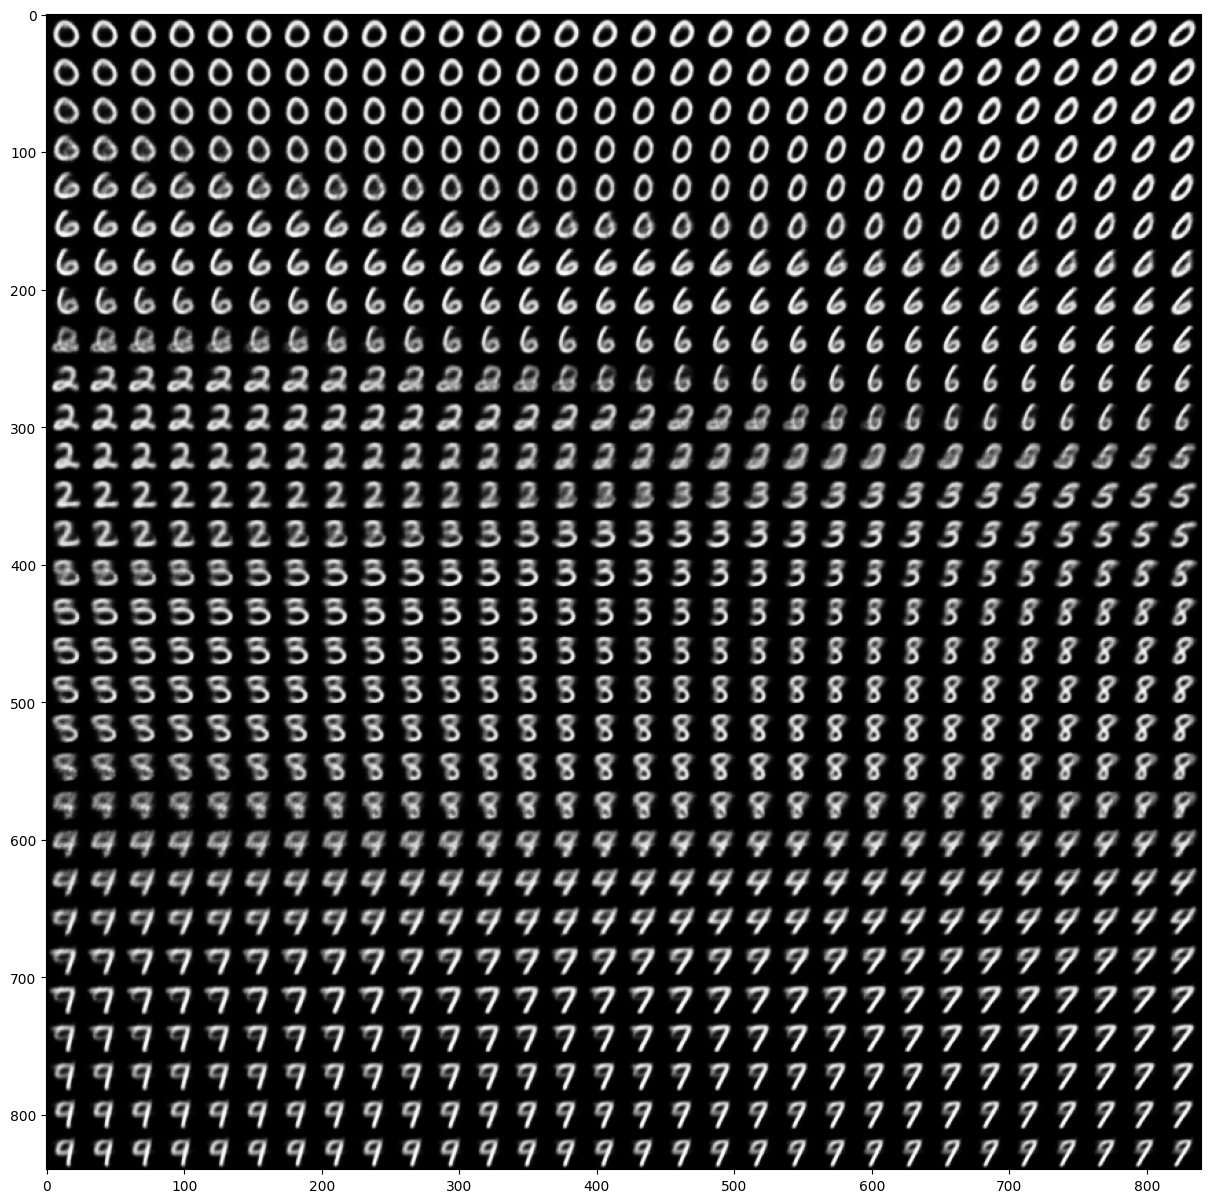

In [31]:
def plot_latent_space(vae, n=30, figsize=15):
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size, j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(figsize, figsize))
    plt.imshow(figure, cmap='Greys_r')
    plt.show()

# Wyświetlenie wygenerowanych cyfr
plot_latent_space(vae)

313/313 [==============================] - 1s 2ms/step


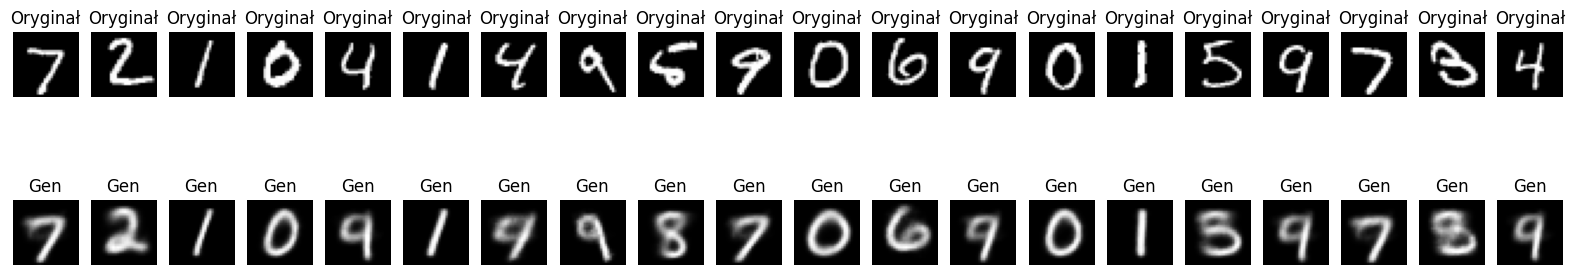

In [33]:
encoded_imgs = encoder.predict(x_test)[2]
decoded_imgs = decoder.predict(encoded_imgs)

num_images = 20
plt.figure(figsize=(20, 4))
for i in range(num_images):
    # Oryginalne obrazy
    ax = plt.subplot(2, num_images, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    plt.title("Oryginał")
    plt.axis('off')

    # Wygenerowane obrazy
    ax = plt.subplot(2, num_images, i + 1 + num_images)
    plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
    plt.title("Gen")
    plt.axis('off')

plt.show()